In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/dataset/USD.csv')
data

,gregorian calendar dates,persian calander dates,first price recorded on the day,lowest price recorded on the day,highest price recorded during the day,last price recorded on the day
0,2011/11/27,1390/09/06,13700,13700,13700,13700
1,2011/11/28,1390/09/07,13440,13440,13440,13440
2,2011/11/29,1390/09/08,13350,13350,13350,13350
3,2011/11/30,1390/09/09,13400,13400,13400,13400
4,2011/12/01,1390/09/10,13500,13500,13500,13500
...,...,...,...,...,...,...
2529,2020/06/11,1399/03/22,177500,177500,177610,177500
2530,2020/06/13,1399/03/24,177550,177500,177610,177560
2531,2020/06/14,1399/03/25,177600,177500,177610,177600
2532,2020/06/15,1399/03/26,177530,177500,178910,178800


In [ ]:


data["gregorian calendar dates"] = pd.to_datetime(data["gregorian calendar dates"])

data

,gregorian calendar dates,persian calander dates,first price recorded on the day,lowest price recorded on the day,highest price recorded during the day,last price recorded on the day
0,2011-11-27,1390/09/06,13700,13700,13700,13700
1,2011-11-28,1390/09/07,13440,13440,13440,13440
2,2011-11-29,1390/09/08,13350,13350,13350,13350
3,2011-11-30,1390/09/09,13400,13400,13400,13400
4,2011-12-01,1390/09/10,13500,13500,13500,13500
...,...,...,...,...,...,...
2529,2020-06-11,1399/03/22,177500,177500,177610,177500
2530,2020-06-13,1399/03/24,177550,177500,177610,177560
2531,2020-06-14,1399/03/25,177600,177500,177610,177600
2532,2020-06-15,1399/03/26,177530,177500,178910,178800


In [ ]:
from sklearn.model_selection import train_test_split

timesteps = 1

train_df, val_df = train_test_split(
  data,
  test_size=0.15,
  random_state=42
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=42
)

x_train = train_df[["first price recorded on the day", "lowest price recorded on the day", "highest price recorded during the day", "last price recorded on the day"]
].values.reshape(-1, timesteps, 4)

x_test = test_df[["first price recorded on the day", "lowest price recorded on the day", "highest price recorded during the day", "last price recorded on the day"]
].values.reshape(-1, timesteps, 4)

x_val = val_df[["first price recorded on the day", "lowest price recorded on the day", "highest price recorded during the day", "last price recorded on the day"]
].values.reshape(-1, timesteps, 4)

In [ ]:
x_train.shape, x_test.shape, x_val.shape

((2153, 1, 4), (126, 1, 4), (255, 1, 4))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),  # Adjusted the output size to match the encoder
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoder()

x_train_tensor = torch.Tensor(x_train)
x_test_tensor = torch.Tensor(x_test)
x_val_tensor = torch.Tensor(x_val)

In [ ]:
# Define DataLoader for training
train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


val_dataset = TensorDataset(x_val_tensor, x_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
import copy

def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum')
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    if (epoch + 1) % 10 == 0:
       print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  x_train_tensor,
  x_val_tensor,
  n_epochs=150
)

Epoch 9: train loss 2696.857793358831 val loss 3411.58560814951
Epoch 19: train loss 2612.2467555264457 val loss 4034.75123314951
Epoch 29: train loss 2313.2933229977066 val loss 1515.620281862745
Epoch 39: train loss 2415.454966090194 val loss 4168.547181372549
Epoch 49: train loss 2318.8892148129066 val loss 1481.1725107230393
Epoch 59: train loss 2270.5490290619196 val loss 3614.1861213235293
Epoch 69: train loss 2270.2082064815086 val loss 2973.5545113357844
Epoch 79: train loss 2164.954215411635 val loss 3488.5154718137255
Epoch 89: train loss 2186.6784882286343 val loss 3245.9969898897057
Epoch 99: train loss 2226.1625919864723 val loss 3750.495343137255
Epoch 109: train loss 2082.6743728772353 val loss 2623.9113511029414
Epoch 119: train loss 2053.292497024501 val loss 3428.6505131740196
Epoch 129: train loss 2073.11404236095 val loss 3720.8141314338236
Epoch 139: train loss 2022.8246836717663 val loss 2876.725467218137
Epoch 149: train loss 1996.8193731312413 val loss 2889.4052

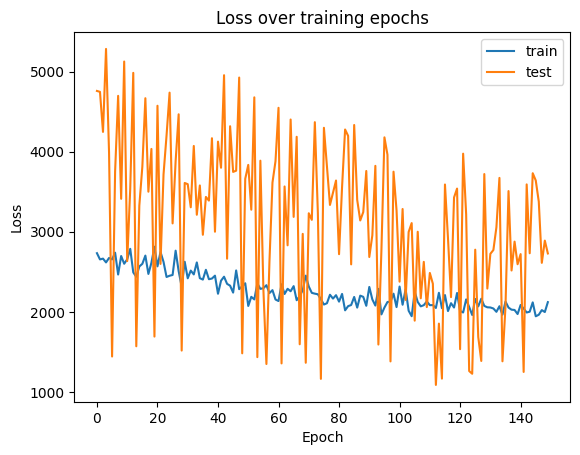

In [ ]:

import matplotlib.pyplot as plt

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/dataset/model.pth'

torch.save(model, MODEL_PATH)

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/dataset/model.pth'

model = torch.load(MODEL_PATH)

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum')
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

<ipython-input-12-7d645fa9dae1>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


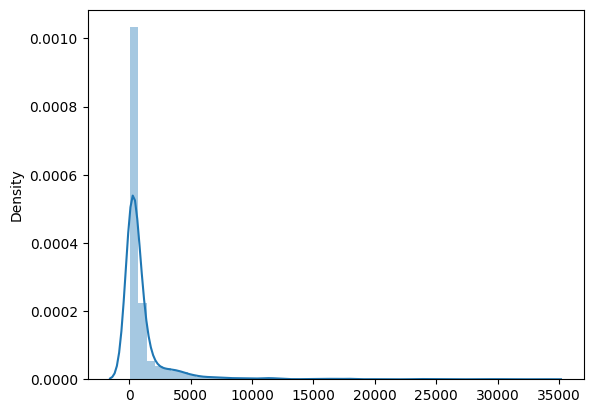

In [ ]:
import seaborn as sns


_, losses = predict(model, x_train_tensor)

sns.distplot(losses, bins=50, kde=True);

<ipython-input-14-00f836aa0463>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


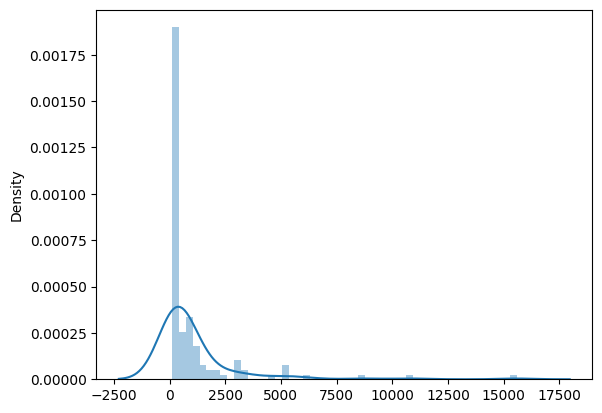

In [ ]:
predictions, pred_losses = predict(model, x_test_tensor)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 10000

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(x_test_tensor)}')

Correct normal predictions: 124/126


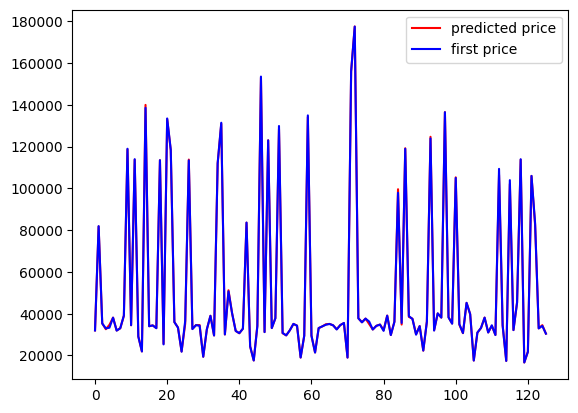

In [ ]:
pred_data = model(x_test_tensor)


plt.plot(pred_data[:,:,0].detach().numpy() , label="predicted price" ,color='red')
plt.plot(x_test_tensor[:,0,0].detach().numpy() , label="first price",color='blue')
plt.legend()
plt.show()

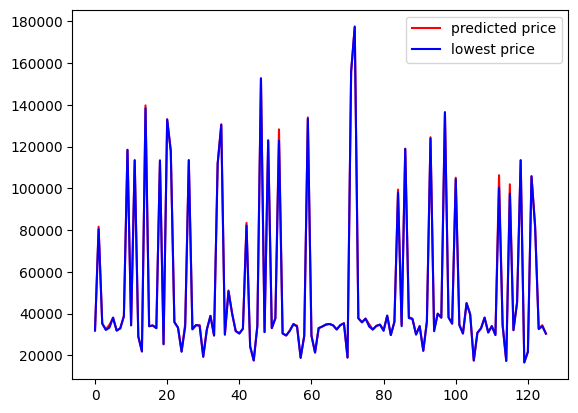

In [ ]:
pred_data = model(x_test_tensor)


plt.plot(pred_data[:,:,1].detach().numpy() , label="predicted price" ,color='red')
plt.plot(x_test_tensor[:,0,1].detach().numpy() , label="lowest price",color='blue')
plt.legend()
plt.show()

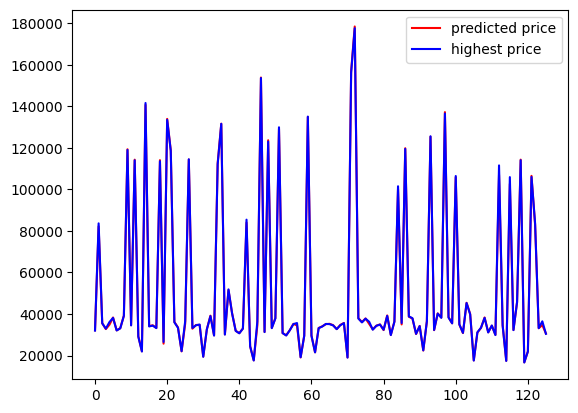

In [ ]:
pred_data = model(x_test_tensor)


plt.plot(pred_data[:,:,2].detach().numpy() , label="predicted price" ,color='red')
plt.plot(x_test_tensor[:,0,2].detach().numpy() , label="highest price",color='blue')
plt.legend()
plt.show()

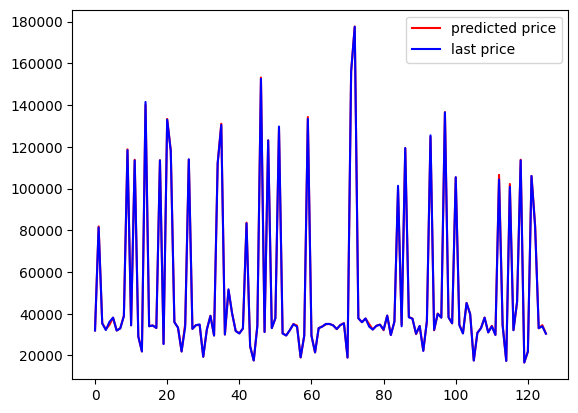

In [ ]:
pred_data = model(x_test_tensor)

plt.plot(pred_data[:,:,3].detach().numpy() , label="predicted price" ,color='red')
plt.plot(x_test_tensor[:,0,3].detach().numpy() , label="last price",color='blue')
plt.legend()
plt.show()

In [ ]:
import torch
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/dataset/USD.csv')
data["gregorian calendar dates"] = pd.to_datetime(data["gregorian calendar dates"])

x = data[["first price recorded on the day", "lowest price recorded on the day", "highest price recorded during the day", "last price recorded on the day"]
].values.reshape(-1, timesteps, 4)
date = data["gregorian calendar dates"]
x = torch.Tensor(x)

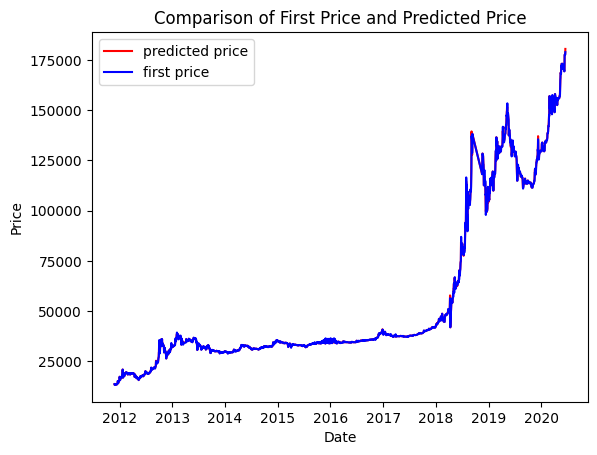

In [ ]:
pred_x = model(x)

plt.plot(date ,pred_x[:,:,0].detach().numpy() , label="predicted price" ,color='red')
plt.plot(date, x[:,:,0].detach().numpy() , label="first price",color='blue')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of First Price and Predicted Price")
plt.legend()
plt.show()

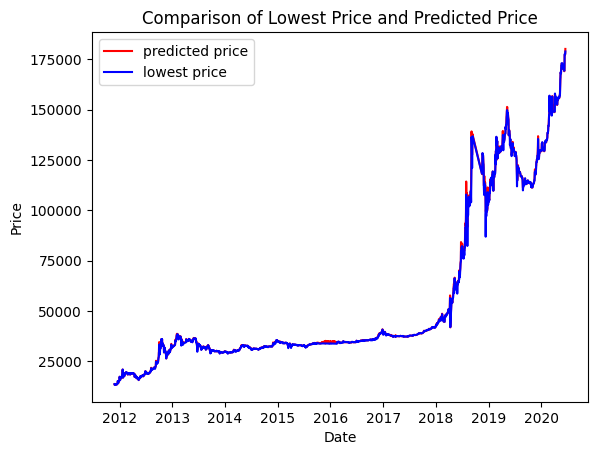

In [ ]:
pred_x = model(x)

plt.plot(date ,pred_x[:,:,1].detach().numpy() , label="predicted price" ,color='red')
plt.plot(date, x[:,:,1].detach().numpy() , label="lowest price",color='blue')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of Lowest Price and Predicted Price")
plt.legend()
plt.show()

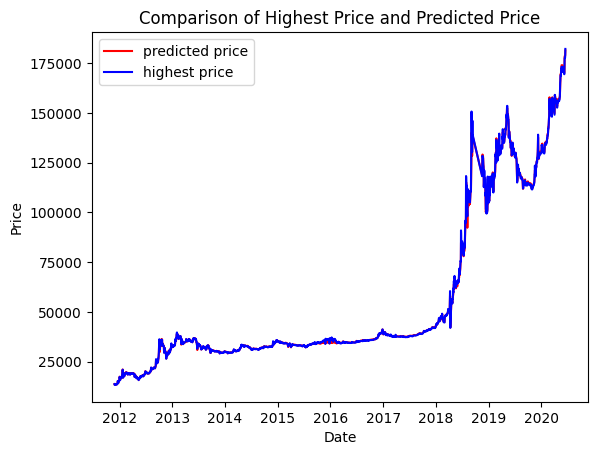

In [ ]:
pred_x = model(x)

plt.plot(date ,pred_x[:,:,2].detach().numpy() , label="predicted price" ,color='red')
plt.plot(date, x[:,:,2].detach().numpy() , label="highest price",color='blue')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of Highest Price and Predicted Price")
plt.legend()
plt.show()

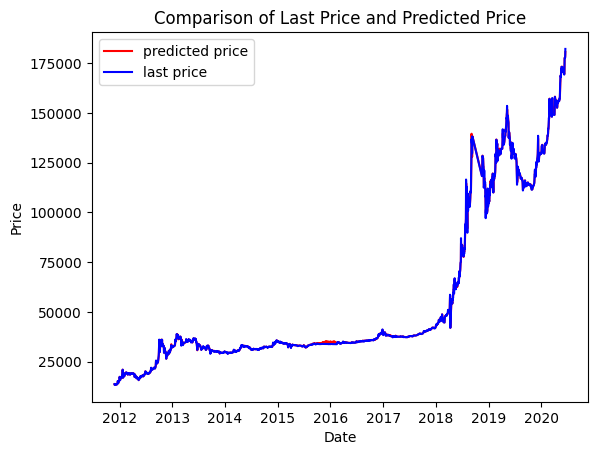

In [ ]:
pred_x = model(x)

plt.plot(date ,pred_x[:,:,3].detach().numpy() , label="predicted price" ,color='red')
plt.plot(date, x[:,:,3].detach().numpy() , label="last price",color='blue')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of Last Price and Predicted Price")
plt.legend()
plt.show()

In [ ]:
import numpy as np


i=0
anomalies = []
criterion = nn.L1Loss(reduction='sum')
with torch.no_grad():
  model = model.eval()
  for seq_true in x:
    seq_pred = model(seq_true)

    loss = criterion(seq_pred, seq_true)

    predictions.append(seq_pred.numpy().flatten())
    if loss.item()>= THRESHOLD:
      values = np.append(seq_true[0,:].detach().numpy(),seq_pred[0,:].detach().numpy(), axis=0)
      anomalies.append((date[i], values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7] ))

  i+=1


In [ ]:
df = pd.DataFrame(anomalies, columns=['Timestamp', 'first', 'lowest', 'highest', 'last','first_pred', 'lowest_pred', 'highest_pred', 'last_pred'])
df

,Timestamp,first,lowest,highest,last,first_pred,lowest_pred,highest_pred,last_pred
0,2011-11-27,81000.0,79620.0,90960.0,87050.0,84420.070312,84253.335938,84832.468750,84457.898438
1,2011-11-27,87000.0,78760.0,89430.0,81550.0,84218.125000,84051.804688,84629.484375,84255.835938
2,2011-11-27,88990.0,88730.0,95340.0,93700.0,91557.929688,91376.132812,92006.687500,91599.726562
3,2011-11-27,103780.0,101000.0,118260.0,116500.0,109789.562500,109569.304688,110331.210938,109841.531250
4,2011-11-27,116550.0,107810.0,117610.0,114700.0,114518.601562,114288.375000,115084.320312,114573.195312
5,2011-11-27,114710.0,95090.0,114890.0,105410.0,108149.695312,107932.914062,108682.976562,108200.750000
6,2011-11-27,105390.0,101010.0,111930.0,105980.0,105947.257812,105735.117188,106469.320312,105997.078125
7,2011-11-27,105990.0,95600.0,113120.0,112960.0,107432.195312,107216.914062,107961.820312,107482.851562
8,2011-11-27,112970.0,102100.0,113370.0,105770.0,108779.460938,108561.335938,109315.945312,108830.851562
9,2011-11-27,105760.0,99000.0,113460.0,101480.0,104590.429688,104381.148438,105105.585938,104639.507812
